The goal of this model is to integrate the diffusion and cell growth model. Such that nutrients will diffuse into the cells from the agar, the cells will then consume nutrients from the concentration gradient. The dt will be selected by the gillespie algorithm from the propensities calculations, this will then be used for the diffusion model. If this dt is larger than the dt constrain on the diffusion model, then the diffusion model will be run a multiple times to match the Gilespie dt.

In [1]:
import multiprocessing
from tqdm.notebook import tqdm
import numpy as np
import scipy.stats as st
import numba

# Plotting modules
import bokeh.io
import bokeh.plotting
import biocircuits

bokeh.io.output_notebook()

# Line profiler (can install with conda install line_profiler)
%load_ext line_profiler

import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import matplotlib.patches as mpatch
from matplotlib.patches import FancyBboxPatch
import time
from matplotlib.animation import *

Loading BokehJS ...

In [187]:
class Cell_Stack:
    def __init__(self):
        self.all_cells = (cell_single(),)
        self.grand_reaction_array = np.array([])
        self.update_reaction_array()
        self.ID_list = []
        self.set_ID(self.all_cells[0] ,'0')

    def set_ID(self, curr_cell, new_ID):
        curr_cell.ID += str(new_ID)
    
    def get_volumes(self):
        return sum([curr_cell.variables["V"] for curr_cell in self.all_cells])
    
    def get_variables(self):
        all_variables = []
        for curr_cell in self.all_cells:
            all_variables.extend(curr_cell.get_variables())
        return all_variables
    
    def get_variables_labels(self):
        return self.all_cells.get_variables_labels()
    
    def update_variables(self, update):
        len_vars = len(self.all_cells[0].variables.values())
        for ind in range(0, len(update), len_vars):
            cell_index = int(np.floor(ind/len_vars))
            self.all_cells[cell_index].update_variables(update[ind:ind+len_vars])
            
    def save_data(self, location, time):
        with open(location, "a+") as f:
            ret_str = str(time)
            for ind in range(len(self.all_cells)):
                ret_str += "/(" + self.all_cells[ind].ID + ")" + str(self.all_cells[ind].get_variables())
            f.write(ret_str+"\n")
            
    def check_split(self):
        ind = 0
        did_split_occur = False
        while ind < len(self.all_cells):
            curr_cell = self.all_cells[ind]
            if curr_cell.variables["V"] > 100:
                out = curr_cell.split_cell()
                self.all_cells[ind].set_variables(out[0,:])
                self.all_cells = self.all_cells[:ind] + (cell_single(),) + self.all_cells[ind:]
                self.all_cells[ind].set_variables(out[1,:])
                self.set_ID(self.all_cells[ind], self.all_cells[ind+1].ID + '0')
                self.set_ID(self.all_cells[ind+1], '1')
                ind = -1
                did_split_occur = True
            ind += 1
        return did_split_occur
                
    def get_stack_propensities(self):
        propensities = np.array([])
        for curr_cell in self.all_cells:
            propensities = np.concatenate((propensities, curr_cell.get_propensities()))
        return propensities
        
    def update_reaction_array(self):
        self.grand_reaction_array = self.all_cells[0].reaction_array
        [r_y, r_x] = np.shape(self.grand_reaction_array)
        cra_y, cra_x = 0, 0
        for curr_cell in self.all_cells[1:]:
            cra_y += r_y
            cra_x += r_x
            self.grand_reaction_array = np.concatenate((np.concatenate((self.grand_reaction_array, np.zeros([cra_y, r_x])), axis=1), np.concatenate((np.zeros([r_y, cra_x]), curr_cell.reaction_array), axis=1)))
    
class cell_single:
    def __init__(self):
        self.variables = {
            "V" : 50,
            "n_i" : 500,
        }
        self.rates = {
            "g" : 0.05
        }
        
        self.ID = ''
        
        #                               V, n_i
        self.reaction_array = np.array([[1, -1], # R1: Consuption of n_i to make V
                                       ], dtype = int)
        
    def get_propensities(self):
#         print(self.variables["n_i"])
#         print(self.rates["g"])
        return np.array([self.variables["n_i"] * self.rates["g"], # R1: Consuption of n_i to make V
                                     ])
    def get_variables(self):
        return list(self.variables.values())
    
    def get_variables_labels(self):
        return list(self.variables.keys())
    
    def set_variables(self, new_variables):
        for ind, curr_key in enumerate(self.variables.keys()):
            self.variables.update({curr_key : new_variables[ind]})
            
    def update_variables(self, update_variables):
        for ind, curr_key in enumerate(self.variables.keys()):
            self.variables.update({curr_key : self.variables[curr_key] + update_variables[ind]})
    
    def split_cell(self):
        out = np.zeros([2, len(self.variables)])
        for ind, key in enumerate(self.variables.keys()):
            r = np.random.uniform(0.25, 0.75)
            out[0, ind] = int(round(r*self.variables[key]))
            out[1, ind] = int(round((1-r)*self.variables[key]))
        return out
    
        

In [188]:
def sample_discrete(probs):
    """Randomly sample an index with probability given by probs."""
    # Generate random number
    q = np.random.rand()
    
    # Find index
    i = 0
    p_sum = 0.0
    while p_sum < q:
        p_sum += probs[i]
        i += 1
    return i - 1
def gillespie_draw(propensities):
#     print("propensities=",propensities)
    # 2) Sum propensities
    propensity_sum = propensities.sum()
    
    # 3) Compute next time
    dt = np.random.exponential(1.0 / propensity_sum)
    
    # 4) Compute reaction probabilites from propensities
    reaction_probabilites = propensities / propensity_sum
    
    # 5) Draw a random reaction
    chosen_reaction = sample_discrete(reaction_probabilites)
    
    return chosen_reaction, dt

In [209]:
# C[0:199] = Agar, C[200:-1] = Biofilm
x_size = 100 # Size of Agar
x_max = 1
dx = x_max/x_size



D =   0.5
D_A = 0.05
A = 100
# D_array = 1/(1+np.exp(-10*(np.linspace(0,x_size-1,x_size)-int(x_size/2))))
# D_array = D_array*(D-D_A) + D_A

D_array = np.ones(x_size)*D_A
t_max = 1000
print((dx*dx)/(2*D))
dt_limit = (dx*dx)/(2*D)
dt = 0.0005
n_iter = int(t_max/dt)

C_max = 100
C = np.ones(x_size)*C_max


0.0001


In [210]:
CS_obj = Cell_Stack()

time_points = np.linspace(0, 100, t_max)
# pop_out = np.empty((len(time_points), CS_obj.grand_reaction_array.shape[1]), dtype = int)

# Initialise and perform simulation
index = 0
time_index = 1
time = time_points[0]
# variables = CS_obj.get_variables()
# pop_out[0,:] = variables
propensities = np.zeros(CS_obj.grand_reaction_array.shape[1])
while index < len(time_points):
    while time < time_points[time_index]:
        # Draw reaction and time step
#         print(CS_obj.get_stack_propensities())
        reaction, dt = gillespie_draw(CS_obj.get_stack_propensities())
#         print(reaction)
        # Update variables
#         variables_previous = CS_obj.get_variables()
#         print(CS_obj.grand_reaction_array[reaction, :])
        CS_obj.update_variables(CS_obj.grand_reaction_array[reaction, :])
        
        new_total_vol = CS_obj.get_volumes()
#         print("new_total_vol", new_total_vol)
#         print("len(C)", len(C))
#         print("x_size", x_size)
#         print("int(new_total_vol- (len(C)-x_size))", int(new_total_vol- (len(C)-x_size)))
        D_array = np.concatenate((D_array, D*np.ones(int(new_total_vol- (len(C)-x_size)))))
        C = np.concatenate((C, np.zeros(int(new_total_vol - (len(C)-x_size)))))
        
        iter_diff_max = int(np.ceil(dt/dt_limit))
        dt_diff = dt/iter_diff_max
        for iter_diff_curr in range(0, iter_diff_max):
            C = C + (dt_diff*(np.gradient(D_array*np.gradient(C, dx, edge_order = 2), dx, edge_order = 2)))
            C[0] = C[1]
            C[-1] = C[-2]
        # Increment time
        time += dt
        

    # Update index
    index = np.searchsorted(time_points > time, True)

    # Update the variables
    CS_obj.save_data("SimData\Trial2\data.txt", time)
    with open("SimData\Trial2\data_C.txt", "a+") as f:
        ret_str = str(time)
        f.write(ret_str + "/" + str(list(C))+"\n")
    # Increment index
    time_index = index
    
    CS_obj.check_split()
    CS_obj.update_reaction_array()
#     pop_out = np.concatenate((pop_out, np.zeros([np.shape(pop_out)[0], np.shape(CS_obj.get_variables())[0]-np.shape(pop_out)[1]])), axis = 1)
    

10114.41762345044
10125.883598275212
10162.631118630903
10183.568257092005
10231.831974594403
10273.568639035731
10305.401381466323
10348.699299835229
10409.5909745821
10431.13594565494
10465.409618336582
10506.505519002372
10539.434968123336
10572.610214037924
10607.644594095082
10685.511908750508
10730.815538576275
10743.183530318069
10788.520606695216
10823.64643545799
10835.587215567952
10847.836239324277
10895.17074030422
10907.178751407824
10919.45017012532
10931.887295192995
10956.677538446156
11027.547263057204
11039.880402823646
11051.983263029197
11087.838381488056
11100.205584317158
11124.537895950787
11149.192663508522
11185.619263997896
11222.217993546474
11270.147067606635
11317.81485136403
11341.627784949967
11353.969853131694
11452.680791647817
11496.346130669412
11519.116375636719
11530.921280714425
11554.222816571368
11577.216810053318
11589.15472678381
11601.086427222961
11624.911869911066
11648.791679769613
11672.362292631407
11684.45623340122
11696.801284934882
117

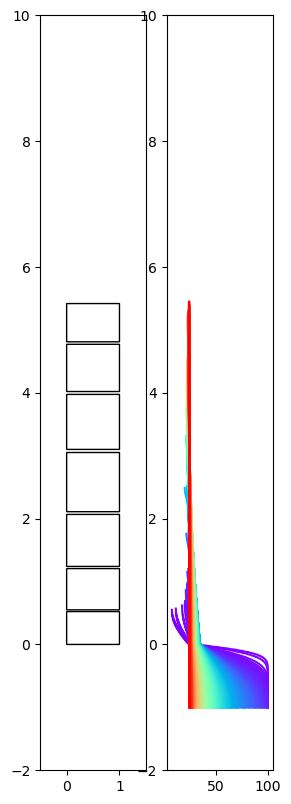

In [211]:
fig, axs = plt.subplots(1,2, figsize = (3,10))
fig.set_dpi(100)
axs[0].set_xlim(-0.5,1.5)
axs[0].set_ylim(-2,10)
# axs[0].set_xlim(-0.5,1.5)
axs[1].set_ylim(-2,10)

with open("SimData\Trial2\data.txt", "r") as f:
    text_raw = f.read()    
text_split_raw = text_raw.split("\n")[:-1]
time_axis = np.array([])

with open("SimData\Trial2\data_C.txt", "r") as f:
    text_C_raw = f.read()    
text_C_split_raw = text_C_raw.split("\n")[:-1]

cell_Boxes = {"0" : FancyBboxPatch((0,0), 1, 50/100, boxstyle = 'round', facecolor = [1,1,1], edgecolor = [0,0,0], animated = True, mutation_scale = 0)}
colors = plt.get_cmap("rainbow", len(text_C_split_raw))

def anim_init():
    axs[0].add_patch(cell_Boxes["0"])

    
# for curr_timepoint in range(len(text_C_split_raw)-1):
#     x_data = [float(curr) for curr in text_C_split_raw[curr_timepoint].split("/")[1:][0][1:-2].split(", ")]
# #     print(x_data)
#     y_data = np.linspace(0, len(x_data), len(x_data))/100
# #     print(y_data)
#     plt.plot(x_data, y_data)
    
def anim_update(frame_number):
#     print(frame_number)
    temp_curr = text_split_raw[frame_number].split("/")[1:]
    x_data_C = [float(C_curr) for C_curr in text_C_split_raw[frame_number].split("/")[1:][0][1:-2].split(", ")]
    y_data_C = (np.linspace(0, len(x_data_C), len(x_data_C))/100)-1
    axs[1].plot(x_data_C, y_data_C, color = colors(frame_number))
    print(sum(x_data_C))
    height_total = 0
    for cell_curr in temp_curr:
        
        id_curr = cell_curr.split(")")[0][1:]
#         print(id_curr)
        cell_volume = cell_curr.split("[")[1].split(",")[0]
        height_new = float(cell_volume)/100
        
        if id_curr in cell_Boxes.keys():
#             print("updated old cell")
            cell_Boxes[id_curr].set_y(height_total)
            cell_Boxes[id_curr].set_height(height_new*0.95)
        elif id_curr in [temp_itr + '0' for temp_itr in cell_Boxes.keys()]:
#             print("updated old cell plus new name")
            cell_Boxes[id_curr[:-1]].remove()
            cell_Boxes[id_curr] = cell_Boxes.pop(id_curr[:-1])
            cell_Boxes[id_curr].set_y(height_total)
            cell_Boxes[id_curr].set_height(height_new*0.95)
            axs[0].add_patch(cell_Boxes[id_curr])
        else:
#             print("added new cell")
            cell_Boxes[id_curr] = FancyBboxPatch((0,height_total), 1, height_new*0.95, boxstyle = 'round', facecolor = [1,1,1], edgecolor = [0,0,0], animated = True, mutation_scale = 0)
            axs[0].add_patch(cell_Boxes[id_curr])
        
        height_total += height_new
    return cell_Boxes
animation = FuncAnimation(fig, anim_update, frames = range(0,len(text_split_raw)), init_func = anim_init, interval = 100)
animation.save('SimData/Trial2/animation1.mp4', fps=30, 
          extra_args=['-vcodec', 'h264', 
                      '-pix_fmt', 'yuv420p'])

In [193]:
sum(C)

16118.782832384757

In [124]:
with open("SimData\Trial2\data_C.txt", "r") as f:
    text_C_raw = f.read()    
text_C_split_raw = text_C_raw.split("\n")
time_axis = np.array([])

In [137]:
text_C_split_raw[4]

'1.0205036562092664/[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 99.9999999999968, 99.99999999999594, 99.99999999998789, 99.99999999998614, 99.9999999999597, 99.99999999995426, 99.99999999986521, 99.99999999984688, 99.99999999955273, 99.9999999994928, 99.99999999854201, 99.99999999835073, 99.9999999953461, 99.99999999474905, 99.99999998546924, 99.99999998364805, 99.99999995564873, 99.99999995022355, 99.9999998677265, 99.9999998519487, 99.99999961469565, 99.9999995699187, 99.99999890423823, 99.99999878029739, 99.99999695895326, 99.9999966245154, 99.99999176742365, 99.99999088812805, 99.99997826987288, 99.99997601851587, 99.99994410048741, 99.99993848989281, 99.99985991997836, 99.99984631848376, 99.99965820302982, 99.99962614560246, 99.99918832101167, 99.99911490703508, 99.99812490043998, 99.99796164297202, 99.99578799756074, 99.99543567550027, 99.99080442286234, 99.99006702996003, 99.98049706098168, 99.9790013031

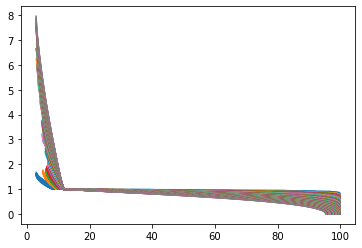

In [163]:
for curr_timepoint in range(len(text_C_split_raw)-1):
    x_data = [float(curr) for curr in text_C_split_raw[curr_timepoint].split("/")[1:][0][1:-2].split(", ")]
#     print(x_data)
    y_data = np.linspace(0, len(x_data), len(x_data))/100
#     print(y_data)
    plt.plot(x_data, y_data)

In [44]:
CS_obj.get_volumes()

51

In [45]:
(len(C)-x_size)

51

In [48]:
len(D_array)

100

In [53]:
str(list(C))

'[100.0, 100.0, 100.0, 99.99999999999662, 99.99999999999612, 99.99999999998755, 99.99999999998656, 99.99999999996432, 99.99999999996022, 99.99999999989875, 99.99999999988702, 99.99999999971253, 99.9999999996799, 99.99999999919385, 99.99999999910379, 99.99999999777361, 99.99999999752971, 99.99999999395409, 99.99999999330517, 99.99999998386636, 99.99999998217133, 99.99999995770852, 99.99999995336256, 99.99999989113184, 99.99999988019715, 99.99999972484929, 99.99999969785883, 99.99999931741266, 99.99999925207332, 99.99999833826759, 99.99999818317968, 99.99999603104231, 99.99999567022039, 99.99999070174499, 99.99998987914682, 99.99997863844676, 99.99997680136553, 99.99995188646768, 99.99994786877208, 99.99989378119706, 99.99988517933589, 99.99977020936805, 99.99975218628168, 99.9995129679091, 99.9994760244432, 99.99898894296535, 99.99891488640299, 99.99794464773946, 99.99779952098999, 99.99590936481353, 99.99563144197312, 99.99203120756931, 99.99151130462847, 99.9848086100735, 99.983858962

In [53]:
len(D_array)

218

In [56]:
np.ones(CS_obj.get_volumes() - (len(C)-x_size))

TypeError: 'numpy.float64' object cannot be interpreted as an integer

In [55]:
CS_obj.get_volumes() - (len(C)-x_size)

1.0